# Restaurant Demo in Clojure

This is a demo for [differential-privacy-clj](https://github.com/OpenMined/clojure-dp), a wrapper for [differential privacy library by Google](https://github.com/google/differential-privacy). The contents of this demo are ported from a differential privacy library [example](https://github.com/google/differential-privacy/tree/123626ff1060d9884a16f04b0d743a72bb08607e/examples/java).

Please run this cell first to provide all dependencies and namespaces:

In [1]:
%classpath add mvn com.google.protobuf protobuf-java 3.11.4
%classpath add mvn org.apache.commons commons-math3 3.6.1
%classpath add mvn com.google.guava guava 28.2-jre
%classpath add mvn org.clojure data.csv 1.0.0
%classpath add mvn incanter incanter 1.9.3


;; Download two jars from a server (temporary solution before release).
%classpath add mvn commons-io commons-io 2.6
(import (java.awt Color)
        (java.io File)
        (java.net URL)
        (java.time LocalTime)
        (java.time.format DateTimeFormatter DateTimeFormatterBuilder)
        (java.util Locale)
        (org.apache.commons.io FileUtils)
        (org.jfree.chart.labels StandardCategoryItemLabelGenerator))

(def dpUrl "http://replomancer.net/OpenMined/libdifferentialprivacy-1.0.jar")
(def dpFile (str (System/getProperty "java.io.tmpdir") "/differentialprivacy-1.0.jar"))
(FileUtils/copyURLToFile (URL. dpUrl) (File. dpFile))
%classpath add dynamic dpFile

(def dp2Url "http://replomancer.net/OpenMined/differential-privacy-clj-0.2.1-SNAPSHOT.jar")
(def dp2File (str (System/getProperty "java.io.tmpdir") "/differential-privacy-clj-0.2.1-SNAPSHOT.jar"))
(FileUtils/copyURLToFile (URL. dp2Url) (File. dp2File))
%classpath add dynamic dp2File


(require '[clojure.data.csv :as csv]
         '[clojure.java.io :as io]
         '[differential-privacy-clj.core :as dp]
         '[incanter.charts :refer [bar-chart add-categories set-stroke-color]])

null

In [2]:
;; We use this function for mapping over dictionary values:
(defn fmap [f m]
  (into (empty m) (for [[k v] m] [k (f v)])))

;; Examples:
;;
;; (fmap inc {:a 1, :b 5}))
;; => {:a 2, :b 6}
;;
;; (fmap str {:a 1, :b true, :c []})
;; => {:a "1", :b "true", :c "[]"})
;;
;; (fmap count {:a [], :b [:x :x :x], :c '("x" "x")}))
;; => {:a 0, :b 3, :c 2}

;; this is a time formatter for timestamps in the CSVs
(def time-formatter
  (-> (DateTimeFormatterBuilder.)
      (.parseCaseInsensitive)
      (.appendPattern "h:mm:ss a")
      (.toFormatter Locale/ENGLISH)))

;; the color of private values bars
(def dp-bar-color (Color/decode "#5555FF"))

#'beaker_clojure_shell_64b1b72e-402b-4c4b-b094-c7c624c27dbe/dp-bar-color

# Restaurant

Imagine a fictional restaurant owner named Alice who would like to share
business statistics with her visitors. Alice knows when visitors enter the
restaurant and how much time and money they spend there. To ensure that
visitors' privacy is preserved, Alice decides to use the Differential Privacy
library.

Here we define the default value for epsilon or the privacy budget we spend on each computation.

In [3]:
(def default-epsilon 1.0)

#'beaker_clojure_shell_64b1b72e-402b-4c4b-b094-c7c624c27dbe/default-epsilon

## Count visits by hour of day

In this example Alice wants to share this information with potential clients in
order to let them know the busiest times in the restaurant. For this, we will
count how many visitors enter the restaurant at every hour of a particular day.
For simplicity, assume that a visitor comes to the restaurant at most once a
day. In other words, a visitor is present at most once in the whole dataset.

Visit data for a single day is stored in the `example_data/restaurant_demo/day_data.csv` file. It includes
the visitor’s ID, the visit duration (in minutes), and the money spent at the
restaurant.

In [4]:
(def day-visits-data
  (with-open [reader (io/reader "../example_data/restaurant_demo/day_data.csv")]
    (let [data (rest (csv/read-csv reader))]  ;; skip the first line (header)
      (mapv (fn [[visitor-id time-entered minutes-spent money-spent]]
                {:visitor-id (Integer. visitor-id)
                 :time-entered (LocalTime/parse time-entered time-formatter)
                 :minutes-spent (Integer. minutes-spent)
                 :money-spent (Integer. money-spent)})
                data))))

(take 5 day-visits-data)

Run the code below to calculate the number of visitors that entered the restaurant
every hour of the day. The calculation is done twice: for non-private values
and for differentially private ones.

For her own use (not for publishing) Alice may produce this statistic:

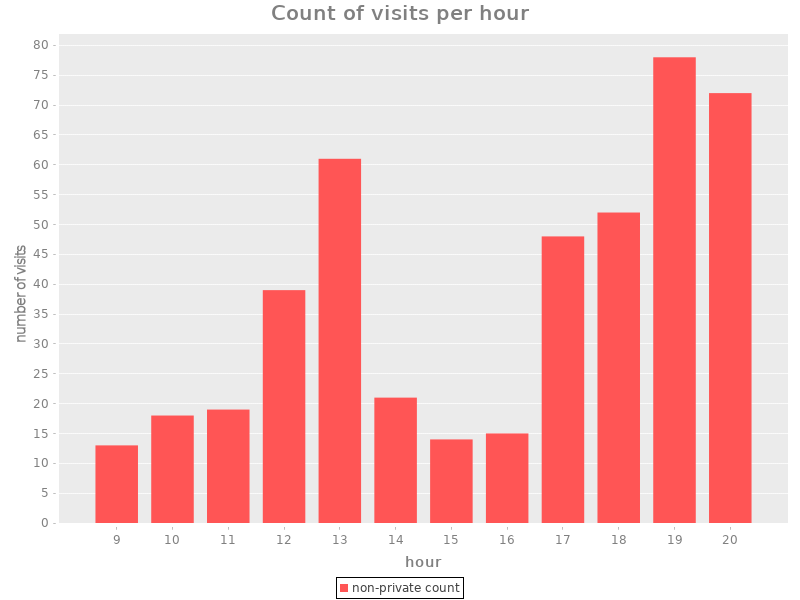

In [5]:
;; Produce a sequence of hours from day-visits-data
;; e.g. [9 11 10 10 11 12 13 12 12 12 14 15 16 18 17 18 17 20 19]
(def visit-hours (map (fn [visit] (.getHour (:time-entered visit)))
                      day-visits-data))

;; Compute non-private frequencies of visits per hour
;; e.g. {9 13, 10 18, 11 19, 12 39, 13 61, 14 21, ...}
(def visits-per-hour
  (->> visit-hours
       frequencies
       (into (sorted-map))))
       
(-> (bar-chart (keys visits-per-hour)
               (vals visits-per-hour)
               :title "Count of visits per hour"
               :series-label "non-private count"
               :x-label "hour" :y-label "number of visits"
               :legend true)
    (.createBufferedImage 800 600))


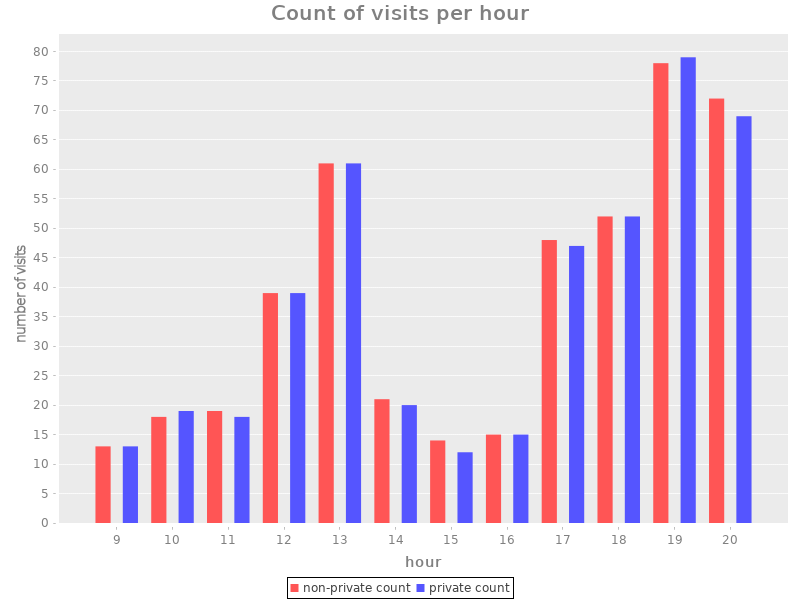

In [6]:
;; Replace true counts with differentially private values.
;; Assume a visitor can enter at most once a day
(def dp-visits-per-hour
  (fmap #(dp/count %
                   :epsilon default-epsilon
                   :max-partitions-contributed 1) ;; partitions are hour-slots
        ;; In PyDP this would be:
        ;; Count(epsilon=default_epsilon, l0_sensitivity=1).quick_result(visits)
        visits-per-hour))

;; Build and show the bar chart.
(-> (bar-chart (keys visits-per-hour)
               (vals visits-per-hour)
               :title "Count of visits per hour"
               :series-label "non-private count"
               :x-label "hour" :y-label "number of visits"
               :legend true)
    (add-categories (keys dp-visits-per-hour)
                    (vals dp-visits-per-hour)
                    :series-label "private count")
    (.createBufferedImage 800 600))
    

You should see a bar chart with the results above. The red (left) bars represent the
counts without anonymization while blue (right) bars correspond to the private
(or *anonymized*) counts. You can see that the private values slightly differ
from the actual ones but the overall trend is preserved. For example, you can
clearly see that the restaurant is more busy during lunch and dinner time.

Note that Differential Privacy involves adding *random noise* to the actual
data, so your results can be slightly different each time you run the code.

This is the bar chart ready for publication (private values only):

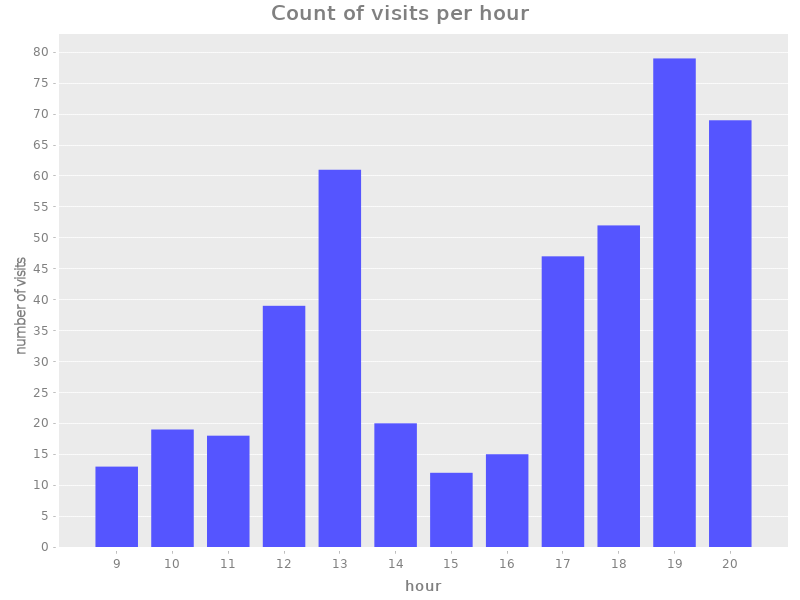

In [7]:
;; Build and show the bar chart.
(-> (bar-chart (keys dp-visits-per-hour)
               (vals dp-visits-per-hour)
               :title "Count of visits per hour"
               :series-label "private count"
               :x-label "hour" :y-label "number of visits")
    (set-stroke-color dp-bar-color)
    (.createBufferedImage 800 600))


## Partitions and contributions

We say that the resulting aggregated data is split into *partitions*. The bar
chart for the private and non-private counts each have 15 partitions, one for
each entry hour.

More generally, a single partition represents a subset of aggregated data
corresponding to a given value of the aggregation criterion. Graphically, a
single partition is represented as a bar on the aggregated bar chart.

We say that a visitor *contributes* to a given partition if their data matches
the partition criterion. For example, if a visitor enters between 8 AM and 9 AM,
they *contribute* to the *8 AM partition*.

Recall that in the the example above, a visitor can enter the restaurant only
once per day. This implies three *contribution bounds*:

*   *Maximum partitions contributed*: to how many partitions can a visitor
    contribute? In our example, a visitor can contribute up to one partition. In
    other words, there is at most one time-slot when a visitor with a given id
    can enter the restaurant.
*   *Maximum contributed value*: what is the maximum value that can be
    contributed by a visitor to a partition? In our example, we count the number
    of visits, so the maximum contributed value is simply *1*.
*   *Maximum contributions per partition*: how many times can a visitor
    contribute to a partition? In our example, a visitor can contribute to a
    partition at most once. In other words, a visitor can enter the restaurant
    only once at a given hour.

Why is this important? Differential Privacy adjusts the amount of noise to mask
contributions of each visitor. More contributions require more noise.

Next, we will demonstrate how to use the library in scenarios where:

*   Visitors can contribute to multiple partitions.
*   Contributed values can be greater than *1*.
*   Visitors can contribute to a partition multiple times.

## Count visits by day of week

The previous example made some over-simplifying assumptions. Now, let’s have a
look at the use-case where visitors can contribute to multiple partitions.

Imagine Alice decides to let visitors know which days are the busiest at her
restaurant. For this, she calculates how many people visit the restaurant every
day of the week. For simplicity, let’s assume a visitor enters the restaurant at
most once a day but multiple times a week.

Visit data for a week is stored in the `example_data/restaurant_demo/week_data.csv` file.

In [8]:
(def week-visits-data
  (with-open [reader (io/reader "../example_data/restaurant_demo/week_data.csv")]
    (let [data (rest (csv/read-csv reader))]  ;; skip the first line (header)
      (mapv (fn [[visitor-id time-entered minutes-spent money-spent weekday-nr]]
                {:visitor-id (Integer. visitor-id)
                 :time-entered (LocalTime/parse time-entered time-formatter)
                 :minutes-spent (Integer. minutes-spent)
                 :money-spent (Double. money-spent)
                 :weekday (Integer. weekday-nr)})
                data))))

(take 5 week-visits-data)

Run the code below to see the visits per weekday bar chart:

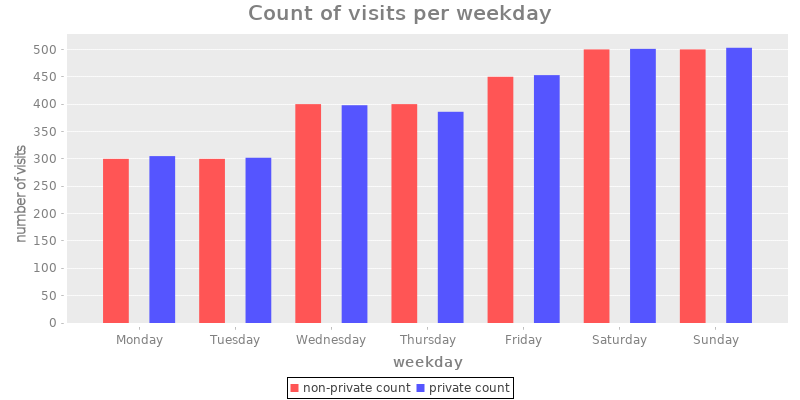

In [9]:
(def all-week-days ["Monday" "Tuesday" "Wednesday" "Thursday" "Friday" "Saturday" "Sunday"])

(def week-days-cnt 7)

;; Compute non-private frequencies of visits per weekday
;; e.g. {1 300, 2 300, 3 400, 4 400, 5 450, 6 500, 7 500}
(def visits-per-day
    (->> week-visits-data
         (map :weekday)
         frequencies
         (into (sorted-map))))

;; Replace true values with differentially private ones.
(def dp-visits-per-day
    (fmap #(dp/count %
                     :epsilon default-epsilon
                     :max-partitions-contributed week-days-cnt)
          visits-per-day))

;; Build and show the bar chart.
(-> (bar-chart all-week-days
               (vals visits-per-day)
               :title "Count of visits per weekday"
               :series-label "non-private count"
               :x-label "weekday"
               :y-label "number of visits"
               :legend true)
    (add-categories all-week-days
                    (vals dp-visits-per-day)
                    :series-label "private count")
    (.createBufferedImage 800 400))

As you can see, the private values slightly differ from the actual ones but the
overall trend is preserved.

As before only the DP statistics are meant for publication:

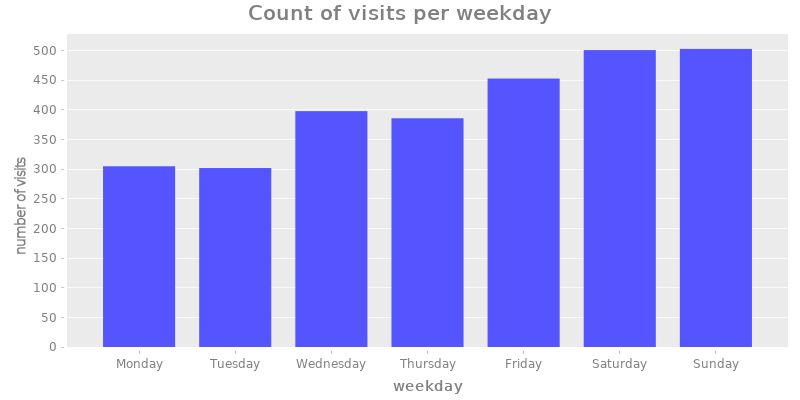

In [10]:
;; Build and show the bar chart.
(-> (bar-chart all-week-days
               (vals dp-visits-per-day)
               :title "Count of visits per weekday"
               :series-label "private count"
               :x-label "weekday"
               :y-label "number of visits")
    (set-stroke-color dp-bar-color)
    (.createBufferedImage 800 400))

In [11]:
;; An estimate of how many times on average a visitor may
;; enter the restaurant per week.
;; All exceeding visits will be discarded by the caller
;; (library user) beforehand.
(def example-max-visits-per-week 3)

;; Data about visits needs some preprocessing because of
;; the example-max-visits-per-week bounding.
;; You don't have to understand this function now.
;; It will be explained in a moment.
(defn remove-exceeding-visits [visits-data max-visits-per-week]
  (let [;; produce a dictionary of visit weekdays e.g.:
        ;;
        ;; {visitor-id1 '(1 3)
        ;;  visitor-id2 '(4 6 2 7)
        ;;  ,,, }
        ;; 
        ;; where no visitor has more than max-visits-per-week
        ;; visit weekdays.
        visitor-weekdays (->> visits-data
                              (group-by :visitor-id)
                              (fmap #(->> %
                                          (map :weekday)
                                          set
                                          shuffle
                                          (take max-visits-per-week))))
        visit-should-be-kept (fn [visit] (some #{(:weekday visit)}
                                               (get visitor-weekdays (:visitor-id visit))))]
    ;; discard exceeding visits
    (filter visit-should-be-kept visits-data)))


(def preprocessed-week-visits-data
    (remove-exceeding-visits week-visits-data example-max-visits-per-week))


(def example-visits-per-day
  (->> preprocessed-week-visits-data
       (map :weekday)
       frequencies
       (into (sorted-map))))


;; Number of visits on Monday.
(def example-monday-visits-count
  (example-visits-per-day 1))


;; Compute DP Count for Monday.
(def example-monday-visits-dp-count
  (dp/count example-monday-visits-count
            :epsilon default-epsilon
            ;; Each visitor may enter the restaurant up to example-max-visits-per-week times per week.
            ;; Hence, each visitor may contribute up to example-max-visits-per-week daily counts.
            :max-partitions-contributed example-max-visits-per-week))


(println "Monday visits")
(println "Non-private count:\t" example-monday-visits-count)
(println "DP count:\t\t" example-monday-visits-dp-count)

(println "Total week visits in the processed dataset (non-private count): "
         (reduce + (vals example-visits-per-day))
         "\nTotal week visits in the unprocessed dataset (non-private count): "
         (reduce + (vals visits-per-day)))

Monday visits
Non-private count:	 278
DP count:		 277
Total week visits in the processed dataset (non-private count):  2693 
Total week visits in the unprocessed dataset (non-private count):  2850


null

You can rerun the previous cell to observe the result changing randomly. Note that even non-private count for Monday is now random, but the non-private count of total visits during the week is not (explanation below).

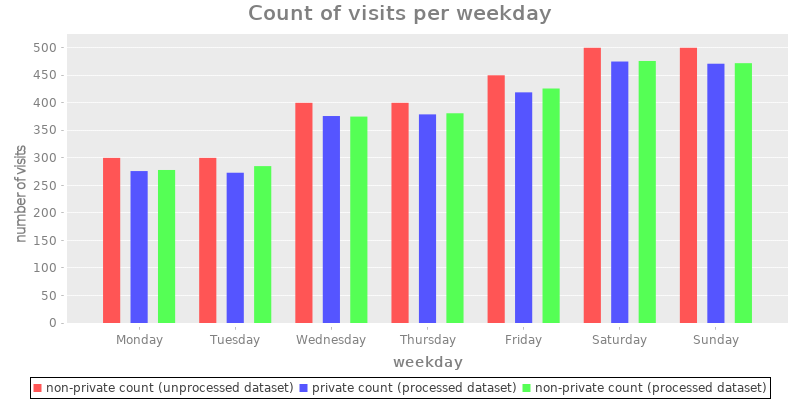

In [12]:
(def dp-example-visits-per-day
    (fmap #(dp/count %
                     :epsilon default-epsilon
                     :max-partitions-contributed example-max-visits-per-week)
          example-visits-per-day))

;; Build and show the bar chart.
(-> (bar-chart all-week-days
               (vals visits-per-day)
               :title "Count of visits per weekday"
               :series-label "non-private count (unprocessed dataset)"
               :x-label "weekday"
               :y-label "number of visits"
               :legend true)
    (add-categories all-week-days
                    (vals dp-example-visits-per-day)
                    :series-label "private count (processed dataset)")
    (add-categories all-week-days
                    (vals example-visits-per-day)
                    :series-label "non-private count (processed dataset)")
    (.createBufferedImage 800 400))

In this case you can see preprocessing has the dataset has visibly distorted the results so the private values are lower than non-private values from the unprocessed dataset. On the other hand we are now adding less noise. The patterns are still visible.

### Bounding the number of contributed partitions

The parameter `:max-partitions-contributed` defines the maximum number of
partitions a visitor may contribute to. You might notice that the value of
`:max-partitions-contributed` in our example is 3 instead of 7. Why is that?
Differential Privacy adds some amount of random noise to hide contributions of
an individual. The more contributions an individual has, the larger the noise
is. This affects the utility of the data. In order to preserve the data utility,
we made an approximate estimate of how many times a week a person may visit a
restaurant on average, and assumed that the value is around 3 instead of scaling
the noise by the factor of 7.

We also pre-processed the input data and discarded all exceeding visits. The
preprocessing is done by the `remove-exceeding-visits` function.
It is important to keep in mind that the library allows you to specify maximum
amount of contributions, but doesn't validate that it is respected.

It is not deterministic which of the exceeding visits we discard during preprocessing,
which also makes the non-private count of Monday visits random. If a visitor
has more than `example-max-visits-per-week` visits and one of those is on Monday
we may or may not discard the Monday visit, but the total number of visits
during the week is constant (in our dataset we will always have 
`example-max-visits-per-week` visits of the frequent visitor).

## Sum-up revenue per day of the week

The previous example demonstrates how the contributed partitions are bounded.
Now, we will demonstrate how individual contributions are clamped. Imagine Alice
decides to calculate the sum of the restaurant revenue per week day in a
differentially private way. For this she needs to sum up the visitors’ daily
spending at the restaurant. For simplicity, let’s assume a visitor enters the
restaurant at most once a day but multiple times a week.

We use the same visit data for a week as before (`example_data/restaurant_demo/week_data.csv` file).

The calculation is done twice: for non-private values and for differentially private ones.

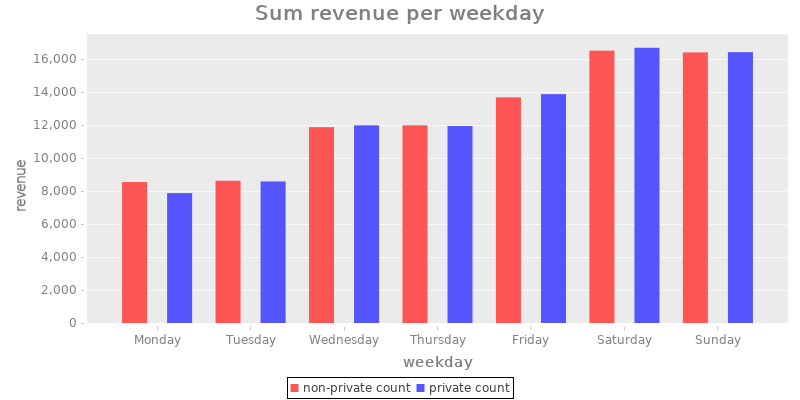

In [13]:
;; Number of weekly visits for a visitor is limited to 4.
;; All exceeding visits will be discarded by the caller
;; (library user) beforehand.
(def revenue-max-visits-per-week 4)


(def revenue-visits-data
  (remove-exceeding-visits week-visits-data revenue-max-visits-per-week))


;; Produce a dictionary of weekday spendings
;; e.g. {1 [10.0 20.0], 2 [5.00 46.0],
;;       3 [], 4 [22.0 13.0 22.0]
;;       5 [1.0], 6 [33.0 12.0 45.0]
;;       7 [49.0 12.0 44.0 12.0]}
(def day-revenue (->> revenue-visits-data
                      (group-by :weekday)
                      (fmap #(map :money-spent %))))

;; Minimum amount of money we expect a visitor to spend on a single visit.
(def min-euros-spent 0)

;; Maximum amount of money we expect a visitor to spend on a single visit.
(def max-euros-spent 50)

;; Compute non-private sums of day revenue (true values).
(def sum-revenue-per-day
  (fmap #(reduce + %)
        day-revenue))

;; Replace true values with differentially private ones.
(def dp-sum-revenue-per-day
  (fmap #(dp/bounded-sum %
                         :epsilon default-epsilon
                         :max-partitions-contributed revenue-max-visits-per-week
                         :lower min-euros-spent
                         :upper max-euros-spent)
        day-revenue))


;; Build and show the bar chart.
(-> (bar-chart all-week-days
               (vals sum-revenue-per-day)
               :title "Sum revenue per weekday"
               :series-label "non-private count"
               :x-label "weekday" :y-label "revenue"
               :legend true)
    (add-categories all-week-days (vals dp-sum-revenue-per-day) :series-label "private count")
    (.createBufferedImage 800 400))



### Clamping individual contributions

The usage of `:max-partitions-contributed` in `dp/bounded-sum` is similar to its usage
in `dp/count`, which is explained in the previous example. This section focuses on
the *lower* and *upper* bounds. The parameters `:lower` and `:upper` of
`dp/bounded-sum` define the *contribution caps*. Every input value will be
automatically clamped to the specified bounds. This is needed for calculating
the sensitivity of the aggregation, and to scale the noise that will be added to
the sum accordingly.

**Choosing bounds**.

The lower and upper bounds affect the utility of the sum in two potentially
opposing ways: reducing the added noise, and preserving the utility. On the one
hand, the added noise is proportional to the maximum of the absolute values of
the bounds. Thus, the closer the bounds are to zero, the less noise is added. On
the other hand, setting the lower and upper bound close to zero may mean that
the input values are clamped more aggressively, which can decrease utility as
well.

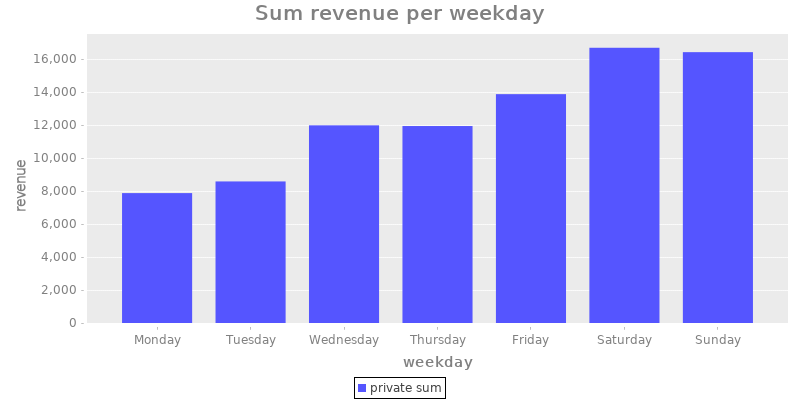

In [14]:
;; Build and show the bar chart.
(-> (bar-chart all-week-days
               (vals dp-sum-revenue-per-day)
               :title "Sum revenue per weekday"
               :series-label "private sum"
               :x-label "weekday" :y-label "revenue"
               :legend true)
    (set-stroke-color dp-bar-color)
    (.createBufferedImage 800 400))

### Why true aggregate values should not be published

You may wonder why it's important to add noise to the aggregate values. Individual's data seems to be unrecoverable even from true statistics. The following explains how even aggregate statistic together with some auxiliary info can reveal sensitive information.

Suppose Alice published true statistics without any noise. Now imagine your friend Bob tells you he was the only person in the restaurant on late Monday evening. If you happen to learn what the daily revenue was until 20:50 (which is just another seemingly safe to publish aggregate value), you can compare this value with what Alice published. Knowing that Bob was the only visitor who could contribute to the difference, you can easily learn how much money Bob spent during his visit.

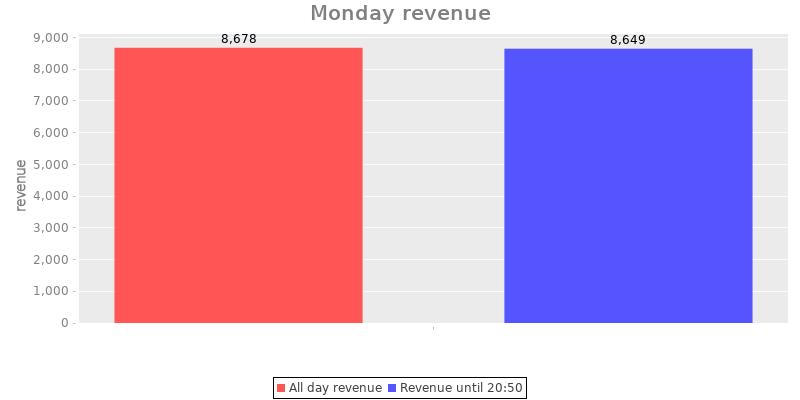

In [15]:
(def monday-visits (filter #(= (:weekday %) 1)
                           week-visits-data))

(def t0 (LocalTime/parse "20:50"))

(def monday-visits-until-t0
    (filter (comp neg? #(.compareTo % t0) :time-entered)
            monday-visits))
        
(def true-monday-revenue
    (reduce + (map :money-spent monday-visits)))

(def true-monday-revenue-until-t0
    (reduce + (map :money-spent monday-visits-until-t0)))

;; Build and show the bar chart.
(-> (doto (bar-chart [" "]
                     [true-monday-revenue]
                     :title "Monday revenue"
                     :series-label "All day revenue"
                     :x-label " "
                     :y-label "revenue"
                     :legend true)
          (-> .getCategoryPlot
              .getRenderer
              (doto (.setItemLabelsVisible true) 
                    (.setBaseItemLabelGenerator (StandardCategoryItemLabelGenerator.)))))
    (add-categories [" "] [true-monday-revenue-until-t0]
                    :series-label "Revenue until 20:50")
    (.createBufferedImage 800 400))

In [16]:
(def bob-spending
    (- true-monday-revenue true-monday-revenue-until-t0))
    
(println "Bob spent exactly" bob-spending "euro!")

Bob spent exactly 29.0 euro!


null